In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn

In [2]:
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [90]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
# psd_stamps = int(N_time / 2 + 1)
t = np.linspace(0, max_time, int(N_time))
gamma = 13e3
gain1 = 1e5
gain2 = 2e5

In [91]:
env = Particle(omega, gamma, radius=73e-9)

In [92]:
print(max_time, (T/4)/delta_t, max_time/delta_t)
print('9.1GB RAM spent')
print('use smallest delta_t such that delay amount is appropriate')
print('commit between max_time and trace amount')

0.006134969325153374 15.337423312883436 30674.846625766873
9.1GB RAM spent
use smallest delta_t such that delay amount is appropriate
commit between max_time and trace amount


In [93]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]/2))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, gain, delta_t, N_time,  M, delay_range):
    cubic_delayed = {i: [None] for i in delay_range}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), key)
            data = np.array(data)
            cubic[i, :] = data
        cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    delay_areas,  areas_std = [], []
    for key in tqdm(list(cubic_delayed.keys())):
        freq, pxx = psd(cubic_delayed[key], delta_t)
        delay_areas.append(pxx.sum(axis=1).mean())
        areas_std.append(pxx.sum(axis=1).std())

    return delay_areas, areas_std, freq

In [94]:
delay_range = range(0,62,1)
areas_gain1, _, _ = generate_traces(env, gain1, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


-- Analysing and making PSD --


100%|██████████| 62/62 [02:13<00:00,  2.16s/it]


In [95]:
areas_gain2, _, _ = generate_traces(env, gain2, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


-- Analysing and making PSD --


100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


In [96]:
areas_ref, areas_std_ref, freq = generate_traces(env, 0, delta_t, N_time, M, [0])

-- Creating traces --


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


-- Analysing and making PSD --


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


In [97]:
def autocor_0(t, omega, gamma, m= 3.368e-18, T = 293):
    C = 2*(gamma*ct.kb*T/m)
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18, T = 293):
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*ct.kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18, T=293):
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m, T=T)
    return T1

In [98]:
theory_delays = np.linspace(0, T, 100)
areas_1 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain1/env._m_, theory_delays, m=env._m_)
areas_2 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain2/env._m_, theory_delays, m=env._m_)

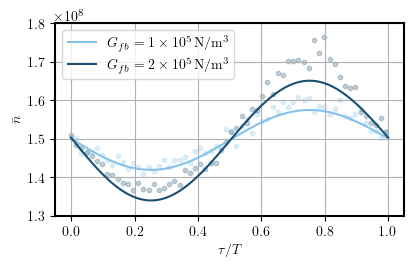

In [100]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.5, 4.2))
fig.set_size_inches(3*1.5, 2.5, forward=True)

plt.plot(theory_delays/T, areas_1/(env.zp_x**2)-1/2, color=colors[1], label=r"$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, np.array(areas_gain1)*np.diff(freq)[0]-1/2,s=10, color=colors[1], alpha=0.25, label=r"_$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")


plt.plot(theory_delays/T, areas_2/(env.zp_x**2)-1/2, color=colors[2], label=r"$G_{fb}=2\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, np.array(areas_gain2)*np.diff(freq)[0]-1/2,s=10, color=colors[2], alpha=0.25, label=r"_$G_{fb}=5.9\times 10^5\,\textrm{N/m}{}^3$")

plt.xlabel(r'$\tau/T$')
plt.ylabel(r'$\bar{n}$')
plt.ylim([1.3e8, 1.8e8])
plt.legend()
plt.grid()
plt.savefig('../plots/area_ratio_vs_delay.pdf', bbox_inches = 'tight')